## Model Building

* **The EDA analysis part along with the introduction of this project has been done in a different notebook.**

The Model Building Process is composed of the following sections:

* Plotting with Matplotlib and Seaborn - Exploratory Data Analysis (EDA)
* Data Preprocessing - We will use Pandas and Numpy for all of our data preprocessing.
* Classification Models from Sklearn Library (Logistic Regression, Tree, SVM, ...)
* K-Fold Cross Validation, Grid Search (Parameter Tuning), and Feature Selection algorithms.

### Importing Libraries

In [199]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

### Reading the data

In [146]:
data = pd.read_csv("data.csv")
data.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [147]:
data.shape

(50000, 12)

In [148]:
data.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked'],
      dtype='object')

In [149]:
data.isnull().sum()

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64

* Features don't have missing values except 'enrolled_date' because not all user have enrolled for the premium version. So we have 18926 users who have not enrolled.

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
user                    50000 non-null int64
first_open              50000 non-null object
dayofweek               50000 non-null int64
hour                    50000 non-null object
age                     50000 non-null int64
screen_list             50000 non-null object
numscreens              50000 non-null int64
minigame                50000 non-null int64
used_premium_feature    50000 non-null int64
enrolled                50000 non-null int64
enrolled_date           31074 non-null object
liked                   50000 non-null int64
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


In [151]:
data.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

* As 'first_open', 'hour', and 'enrolled_date' are datetime objects but in our dataset they are of object type there is a need to convert them.

In [152]:
## Removing some duplicate records

data.drop_duplicates(keep="first", inplace=True)
data.shape

(49985, 12)

In [153]:
## Converting to Datetime type

data["first_open"] = pd.to_datetime(data["first_open"], yearfirst=True)
data["enrolled_date"] = pd.to_datetime(data["enrolled_date"], yearfirst=True)
data["hour"] = data.hour.str.slice(1, 3).astype(int)

In [154]:
data.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [155]:
data.enrolled.value_counts()

1    31067
0    18918
Name: enrolled, dtype: int64

In [156]:
## Correlation Matrix

pd.set_option('display.float_format', '{:.2}'.format)
data.corr()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked
user,1.0,-0.0025,-0.012,-0.0034,4.8e-05,0.0065,0.0041,-0.00053,0.0074
dayofweek,-0.0025,1.0,0.013,-0.012,0.008,-0.0086,0.0016,0.011,-0.0057
hour,-0.012,0.013,1.0,0.019,-0.077,-0.0091,0.023,-0.067,-0.0017
age,-0.0034,-0.012,0.019,1.0,-0.13,0.02,0.0042,-0.13,-0.0026
numscreens,4.8e-05,0.008,-0.077,-0.13,1.0,0.041,0.062,0.21,-0.0074
minigame,0.0065,-0.0086,-0.0091,0.02,0.041,1.0,0.11,0.1,-0.012
used_premium_feature,0.0041,0.0016,0.023,0.0042,0.062,0.11,1.0,-0.053,0.0017
enrolled,-0.00053,0.011,-0.067,-0.13,0.21,0.1,-0.053,1.0,-0.0071
liked,0.0074,-0.0057,-0.0017,-0.0026,-0.0074,-0.012,0.0017,-0.0071,1.0


## Feature Engineering

We need to understand the time a user takes to register for the premium offer. To do so, we need to know the average time for a user to register.

We need to measure the difference between 'first_open' and 'enrolled_date', and save it in a new column.

In [157]:
data.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [158]:
## Here the difference is calculated in terms of hours.

data['difference'] = (data.enrolled_date - data.first_open).astype('timedelta64[h]')
data.sample(10)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,difference
46269,108638,2013-02-24 06:35:43.131,6,6,19,"joinscreen,product_review,product_review2,Scan...",14,0,1,1,2013-02-24 06:49:10.827,0,0.0
44882,194064,2013-01-31 16:38:17.261,3,16,23,"Loan2,CommunityAndInvites,Leaderboard,Alerts,C...",41,0,0,1,2013-02-03 02:03:05.100,0,5.7e+01
33421,307857,2013-07-07 09:54:05.783,6,9,18,ScanPreview,1,0,0,1,2013-07-07 11:57:05.235,0,2.0
36700,248278,2013-04-06 07:57:58.006,5,7,31,"Loan2,ScanPreview,VerifyPhone,VerifyToken,Veri...",21,0,0,1,2013-06-16 11:25:43.893,1,1.7e+03
454,103177,2013-06-15 06:39:54.596,5,6,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",34,0,1,1,2013-06-15 06:43:24.560,0,0.0
48362,147407,2013-03-20 17:14:26.342,2,17,20,"idscreen,joinscreen,Cycle,product_review,produ...",30,0,1,1,2013-04-21 00:04:28.290,0,7.5e+02
45716,263584,2013-05-20 06:52:21.351,0,6,20,"Splash,idscreen,Cycle,product_review,Home,Scan...",6,0,0,0,NaT,0,nan
18054,78453,2013-04-04 03:12:31.528,3,3,24,"Home,Alerts,Institutions,SelectInstitution,Ban...",50,0,0,0,NaT,0,nan
23314,306260,2013-02-15 04:30:15.129,4,4,42,"Home,Loan2,Credit3Container,location,VerifyDat...",16,1,0,1,2013-02-15 04:30:56.229,0,0.0
45235,288636,2013-04-15 20:05:59.626,0,20,33,"Cycle,Home,ScanPreview,VerifyPhone,VerifySSN,C...",22,0,0,1,2013-04-15 20:06:54.107,0,0.0


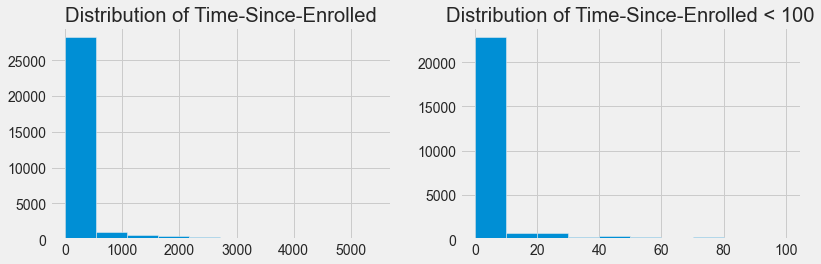

In [159]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(data['difference'].dropna())
plt.title('Distribution of Time-Since-Enrolled');

plt.subplot(2, 2, 2)
plt.hist(data['difference'].dropna(), range=[0, 100])
plt.title('Distribution of Time-Since-Enrolled < 100');

We notice that most of the users enroll within the first 20 to 30 hours. We can infer that 50 hours is a good cut-off time  to test the response of the users. So every user that enrolled after 50 hours can be considered as Non-enrolled for checking the accurate response of the users.

In [160]:
data.loc[data.difference > 50, 'enrolled'] = 0

Now, we no-longer need 'difference', 'enrolled_date', and 'first_open' so we will drop them.

In [161]:
data.drop(columns=['difference', 'enrolled_date', 'first_open'], axis=1, inplace=True)

Now, we are going to analyze the 'screen_list' feature. We can find the most important features (The feature that is more commonly used by the users) by counting them.

In [162]:
## Using Counter to get the screen names

from collections import Counter

list_of_screens = Counter()

for screens in data.screen_list.str.split(','):
    list_of_screens.update(screens)

print(f'We have {len(list_of_screens)} number of screens.')  

top_screens = [screen[0] for screen in list_of_screens.most_common(50)]

print(sorted(top_screens))

We have 137 number of screens.
['Alerts', 'BankVerification', 'CC1', 'CC1Category', 'CommunityAndInvites', 'Credit1', 'Credit2', 'Credit3', 'Credit3Container', 'Credit3Dashboard', 'Cycle', 'EditProfile', 'Finances', 'Home', 'Institutions', 'Leaderboard', 'Loan1', 'Loan2', 'Loan3', 'MLWebView', 'ProfileChildren', 'ProfileEducation', 'ProfileEducationMajor', 'ProfileMaritalStatus', 'ProfilePage', 'ReferralContainer', 'RewardsContainer', 'Saving1', 'Saving10', 'Saving4', 'Saving8', 'Saving9', 'ScanPreview', 'SelectInstitution', 'Settings', 'Splash', 'VerifyCountry', 'VerifyDateOfBirth', 'VerifyHousing', 'VerifyHousingAmount', 'VerifyMobile', 'VerifyPhone', 'VerifySSN', 'VerifyToken', 'idscreen', 'joinscreen', 'location', 'product_review', 'product_review2', 'product_review3']


In [163]:
## Most common screens along with their frequency

list_of_screens.most_common(50)

[('product_review', 94201),
 ('Home', 38089),
 ('ScanPreview', 28347),
 ('VerifyPhone', 26227),
 ('location', 25881),
 ('Loan2', 25312),
 ('VerifyDateOfBirth', 23668),
 ('VerifySSN', 21542),
 ('VerifyCountry', 21155),
 ('VerifyToken', 20330),
 ('product_review3', 19608),
 ('SelectInstitution', 19592),
 ('Cycle', 17771),
 ('product_review2', 17125),
 ('idscreen', 17028),
 ('Credit3Container', 16485),
 ('BankVerification', 15898),
 ('Institutions', 14645),
 ('joinscreen', 13314),
 ('Splash', 10035),
 ('Credit1', 9738),
 ('Credit3Dashboard', 9527),
 ('ReferralContainer', 8442),
 ('ProfilePage', 7900),
 ('Loan3', 7157),
 ('Credit2', 5399),
 ('Credit3', 4885),
 ('Loan1', 4599),
 ('CC1', 4369),
 ('RewardsContainer', 4195),
 ('CommunityAndInvites', 4027),
 ('MLWebView', 3827),
 ('Finances', 3816),
 ('Settings', 3490),
 ('Alerts', 3456),
 ('Saving9', 3004),
 ('CC1Category', 2996),
 ('Saving8', 2784),
 ('VerifyMobile', 2692),
 ('Saving1', 2626),
 ('Leaderboard', 2576),
 ('Saving10', 2455),
 ('E

* We need to create a column for each of those top screens.

In [164]:
data["screen_list"] = data.screen_list.astype(str) + ','

for sc in top_screens:
    data[sc] = data.screen_list.str.contains(sc).astype(int)
    data['screen_list'] = data.screen_list.str.replace(sc + ',', '')

In [165]:
data.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked,...,Leaderboard,Saving10,EditProfile,ProfileMaritalStatus,ProfileChildren,Saving4,VerifyHousing,ProfileEducation,VerifyHousingAmount,ProfileEducationMajor
0,235136,3,2,23,"ProfileForgotPassword,Login,",15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,333588,6,1,24,,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,254414,1,19,23,"Loan,",3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,"Rewards,RewardDetail,",40,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,51549,1,18,31,,32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


* To get value of the left over screens, we'll create a new column 'other' that saves the number of left screens.

In [166]:
data['Other'] = data.screen_list.str.count(',')

In [167]:
data.drop('screen_list', axis=1, inplace=True)

In [168]:
data.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,...,Saving10,EditProfile,ProfileMaritalStatus,ProfileChildren,Saving4,VerifyHousing,ProfileEducation,VerifyHousingAmount,ProfileEducationMajor,Other
0,235136,3,2,23,15,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


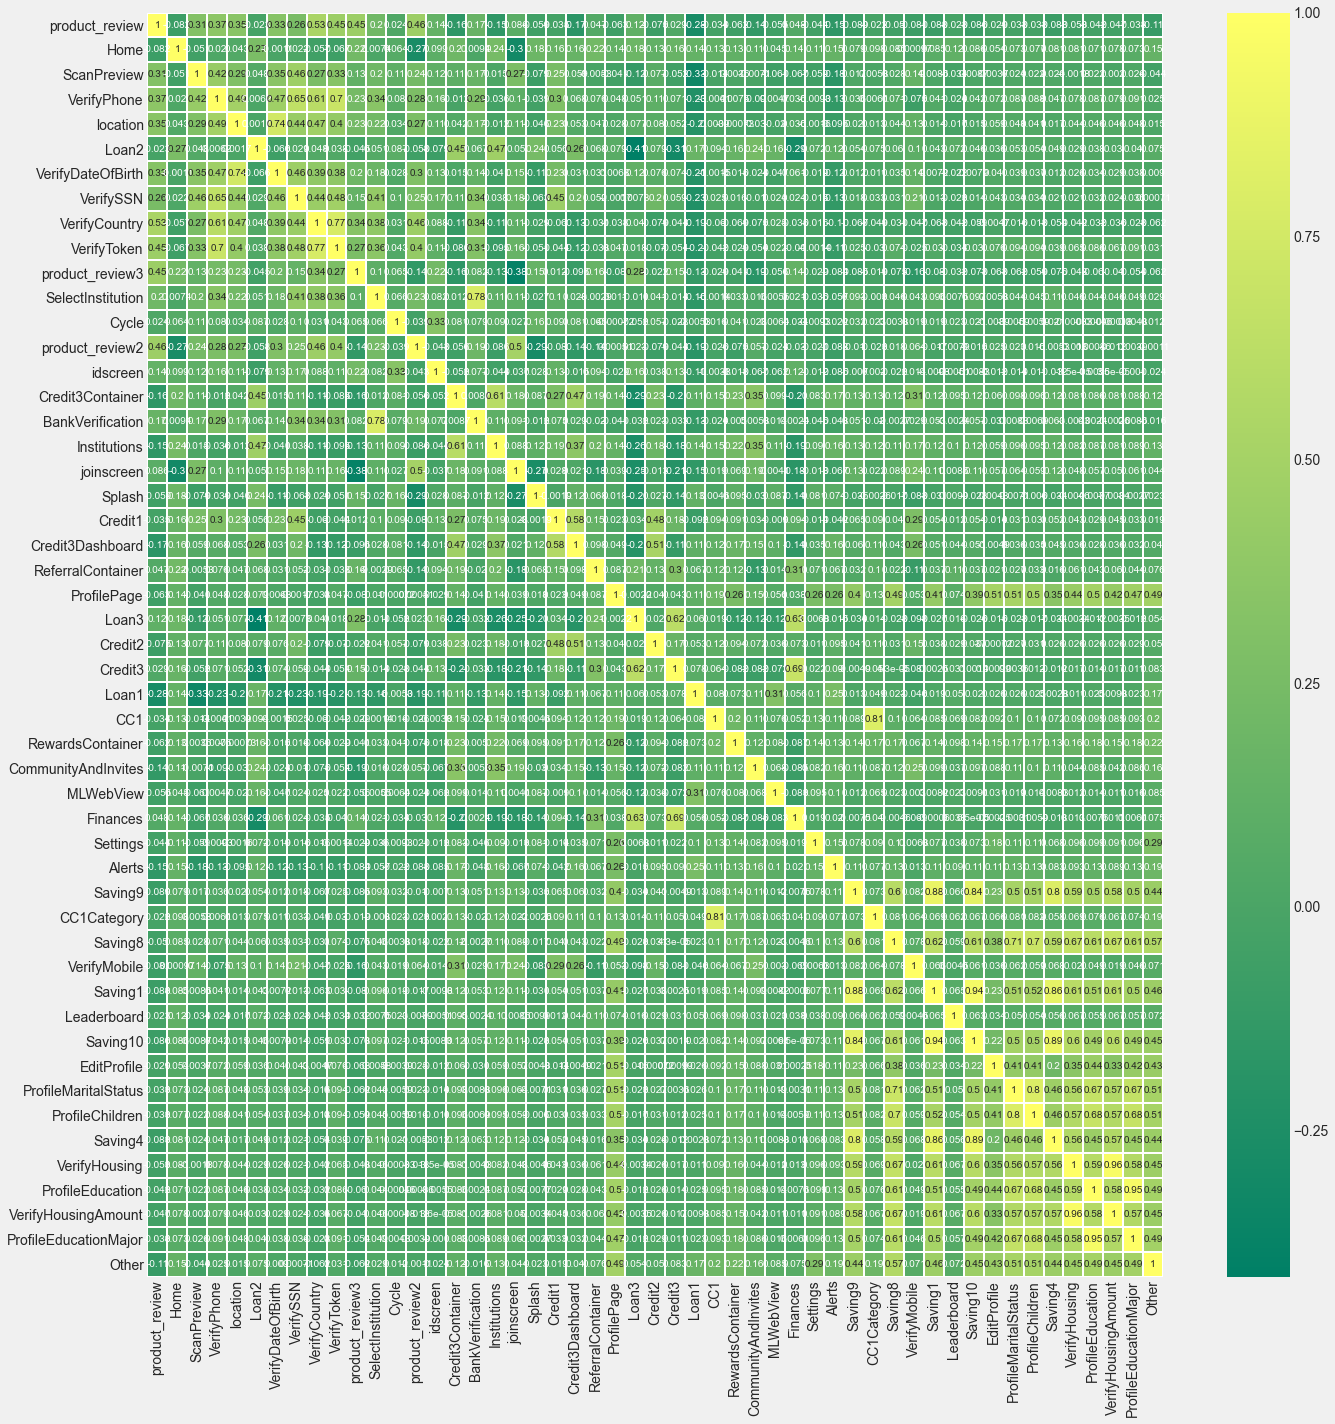

In [169]:
## Now we will find the highly correlated columns and then delete them

plt.figure(figsize=(20, 20))
sns.heatmap(data.iloc[:,9:].corr(),annot=True, linewidth = 1, cmap='summer', annot_kws={'size':10})
plt.tight_layout()
plt.show()

* The saving columns are highly correlated, so we need to delete them. But before so we need to create a SavingsCount feature. The same for Credit, CreditCards, and Loan.

In [170]:
savings_screens = ["Saving1", "Saving4", "Saving8", "Saving9", "Saving10"]

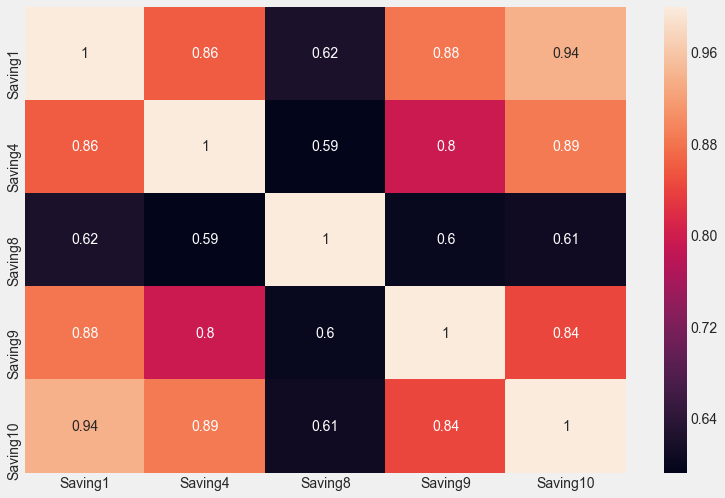

In [171]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[savings_screens].corr(), annot=True)
plt.show()

In [172]:
data[savings_screens].sum()

Saving1     2769
Saving4     2224
Saving8     2784
Saving9     3004
Saving10    2455
dtype: int64

In [173]:
data['SavingsCount'] = data[savings_screens].sum(axis=1)
data.drop(savings_screens, axis=1, inplace=True)

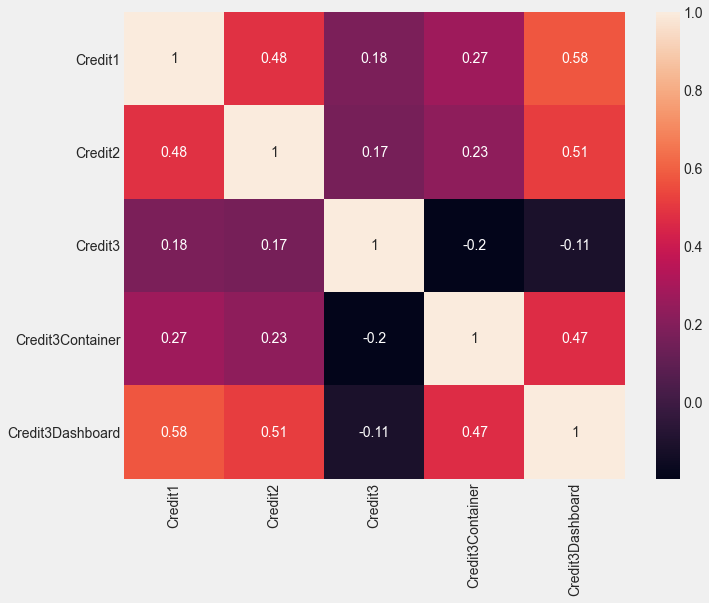

In [174]:
cm_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"]
data["CMCount"] = data[cm_screens].sum(axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(data[cm_screens].corr(), annot=True)
plt.show()

In [175]:
data.drop(cm_screens, axis=1, inplace=True)

In [176]:
data['CMCount']

0        0
1        0
2        0
3        3
4        2
        ..
49995    2
49996    0
49997    0
49998    0
49999    0
Name: CMCount, Length: 49985, dtype: int64

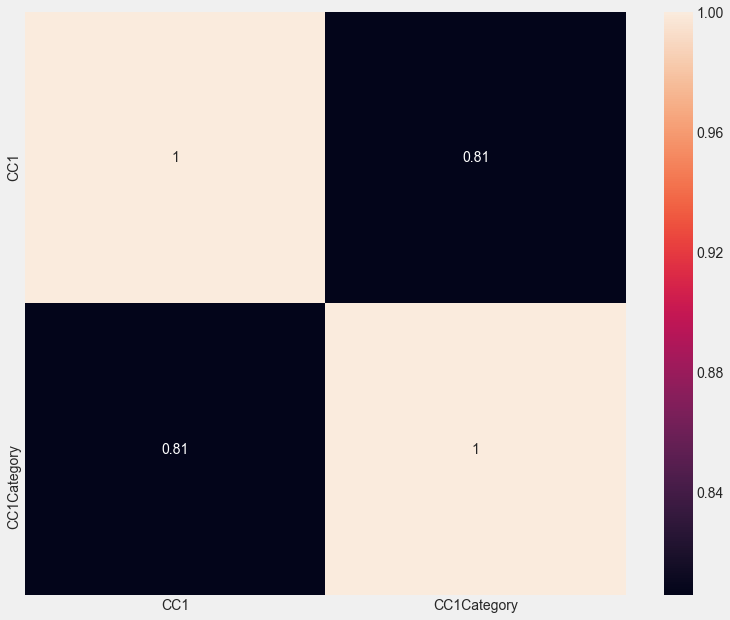

In [177]:
cc_screens = ["CC1", "CC1Category"]
data['CCCount'] = data[cc_screens].sum(axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(data[cc_screens].corr(), annot=True)
plt.show()

In [178]:
data.drop(cc_screens, axis=1, inplace=True)

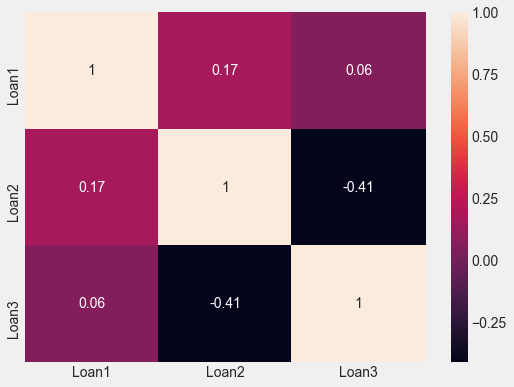

In [179]:
loan_screens = ["Loan1", "Loan2", "Loan3"]
data["LoansCount"] = data[loan_screens].sum(axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(data[loan_screens].corr(), annot=True)
plt.show()

In [180]:
data.drop(loan_screens, axis=1, inplace=True)

In [181]:
data.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,...,ProfileChildren,VerifyHousing,ProfileEducation,VerifyHousingAmount,ProfileEducationMajor,Other,SavingsCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,2,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,2,0,1


In [182]:
pd.set_option('display.float', "{:.2f}".format)
data.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,...,ProfileChildren,VerifyHousing,ProfileEducation,VerifyHousingAmount,ProfileEducationMajor,Other,SavingsCount,CMCount,CCCount,LoansCount
count,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,...,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00,49985.00
mean,186903.05,3.03,12.56,31.72,21.10,0.11,0.17,0.50,0.17,0.71,...,0.05,0.05,0.05,0.04,0.04,0.67,0.26,0.93,0.15,0.74
std,107771.06,2.03,7.44,10.80,15.73,0.31,0.38,0.50,0.37,0.45,...,0.21,0.21,0.21,0.20,0.20,1.42,1.01,1.22,0.50,0.61
min,13.00,0.00,0.00,16.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,93528.00,1.00,5.00,24.00,10.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,187210.00,3.00,14.00,29.00,18.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,280000.00,5.00,19.00,37.00,28.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
max,373662.00,6.00,23.00,101.00,325.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,20.00,5.00,5.00,2.00,2.00


## Data Preprocessing

We will be converting the 'age' data into age groups to get more accuracy and also convert the categorical variables into dummy variables.

In [183]:
def age_group(age):
    if 25 > age >= 16:
        return 1
    elif 30 > age >= 25:
        return 2
    elif 40 > age >= 30:
        return 3
    elif 50 > age >= 40:
        return 4
    elif 60 > age >= 50:
        return 5
    elif age >= 60:
        return 6

In [184]:
data['age'] = data.age.apply(age_group)

In [185]:
data = pd.get_dummies(data, columns=['dayofweek', 'age'], drop_first=True)
data.head()

,user,hour,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,Home,ScanPreview,...,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,age_2,age_3,age_4,age_5,age_6
0,235136,2,15,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
1,333588,1,13,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,254414,19,3,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,16,40,0,0,1,0,1,1,1,...,0,0,1,0,0,1,0,0,0,0
4,51549,18,32,0,0,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [186]:
user_id = data.user
data.drop('user', axis=1, inplace=True)

In [187]:
print(data.shape)

(49985, 57)


In [188]:
## Remove Duplicate Features
data = data.T.drop_duplicates()
data = data.T

## Remove Duplicate Rows
data.drop_duplicates(inplace=True)

In [189]:
print(data.shape)

(49844, 57)


* Some duplicate rows have been removed from the dataset.

In [190]:
data.head(10)

,hour,numscreens,minigame,used_premium_feature,enrolled,liked,product_review,Home,ScanPreview,VerifyPhone,...,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,age_2,age_3,age_4,age_5,age_6
0,2,15,0,0,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,1,13,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,19,3,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,40,0,0,1,0,1,1,1,1,...,0,0,1,0,0,1,0,0,0,0
4,18,32,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
5,9,14,0,0,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
6,2,3,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
7,3,41,0,1,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
8,14,33,1,1,0,0,1,1,1,1,...,1,0,0,0,0,1,0,0,0,0
9,18,19,0,0,1,0,1,1,1,1,...,0,0,1,0,0,1,0,0,0,0


* At this point we can try to export our processed dataset for further usage. But due to computational limitations, further model building will be done on a part of the data only.

In [191]:
df = data[:5000]

In [192]:
df['enrolled'].value_counts()

0    2508
1    2492
Name: enrolled, dtype: int64

* We can see that the target columns is not imbalanced and therefore we can proceed with this small dataset for model building.
* Feature scaling may not be necessary as almost all the values are either 1 or 0. 
* Note: There was no big difference in the accuracy after feature scaling.

In [193]:
## Splitting the data into dependent and independent variables

X = df.drop('enrolled', axis=1)
y = df.enrolled

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3350, 56)
(1650, 56)
(3350,)
(1650,)


In [195]:
## Try doing feature selection to get the best features for the model

## Model Building

We have gained some insights from the EDA part. But with that, we cannot accurately predict or tell whether a user will opt for the premium version or not. So now we will predict that using some great Classification Algorithms. Following are the algorithms I will use to make the model:

1. Logistic Regression

2. Support Vector Machines(Linear)

3. Random Forest

4. K-Nearest Neighbours

5. Naive Bayes

6. Decision Tree


In [200]:
## Importing all the required ML packages

from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [201]:
X_train.columns

Index(['hour', 'numscreens', 'minigame', 'used_premium_feature', 'liked',
       'product_review', 'Home', 'ScanPreview', 'VerifyPhone', 'location',
       'VerifyDateOfBirth', 'VerifySSN', 'VerifyCountry', 'VerifyToken',
       'product_review3', 'SelectInstitution', 'Cycle', 'product_review2',
       'idscreen', 'BankVerification', 'Institutions', 'joinscreen', 'Splash',
       'ReferralContainer', 'ProfilePage', 'RewardsContainer',
       'CommunityAndInvites', 'MLWebView', 'Finances', 'Settings', 'Alerts',
       'VerifyMobile', 'Leaderboard', 'EditProfile', 'ProfileMaritalStatus',
       'ProfileChildren', 'VerifyHousing', 'ProfileEducation',
       'VerifyHousingAmount', 'ProfileEducationMajor', 'Other', 'SavingsCount',
       'CMCount', 'CCCount', 'LoansCount', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'age_2',
       'age_3', 'age_4', 'age_5', 'age_6'],
      dtype='object')

### Logistic Regression

In [202]:
model_1 = LogisticRegression()
model_1.fit(X_train,y_train)
prediction1 = model_1.predict(X_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_test,prediction1))

The accuracy of the Logistic Regression is 0.8290909090909091


### Linear Support Vector Machine

In [203]:
model_2 = svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model_2.fit(X_train,y_train)
prediction2 = model_2.predict(X_test)
print('Accuracy for linear SVM is',metrics.accuracy_score(y_test, prediction2))

Accuracy for linear SVM is 0.8321212121212122


### Random Forest Classifier

In [204]:
model_3 = RandomForestClassifier(n_estimators=100, random_state= 1)
model_3.fit(X_train,y_train)
prediction3 = model_3.predict(X_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(y_test, prediction3))

The accuracy of the Random Forests is 0.8242424242424242


### Decision Tree

In [205]:
model_4 = DecisionTreeClassifier()
model_4.fit(X_train,y_train)
prediction4 = model_4.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(y_test, prediction4))

The accuracy of the Decision Tree is 0.7242424242424242


### K-Nearest Neighbours(KNN)

In [206]:
model_5 = KNeighborsClassifier() 
model_5.fit(X_train,y_train)
prediction5 = model_5.predict(X_test)
print('The accuracy of the KNN is',metrics.accuracy_score(y_test, prediction5))

The accuracy of the KNN is 0.693939393939394


Now the accuracy for the KNN model changes as we change the values for **n_neighbours** attribute. Let's check the accuracies over various values of n_neighbours.

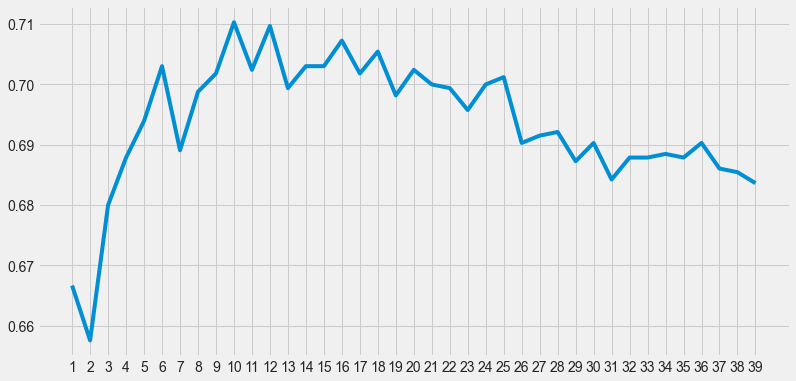

Accuracies for different values of n are: [0.66666667 0.65757576 0.68       0.68787879 0.69393939 0.7030303
 0.68909091 0.69878788 0.70181818 0.71030303 0.70242424 0.70969697
 0.69939394 0.7030303  0.7030303  0.70727273 0.70181818 0.70545455
 0.69818182 0.70242424 0.7        0.69939394 0.69575758 0.7
 0.70121212 0.69030303 0.69151515 0.69212121 0.68727273 0.69030303
 0.68424242 0.68787879 0.68787879 0.68848485 0.68787879 0.69030303
 0.68606061 0.68545455 0.68363636] with the max value as  0.7103030303030303


In [207]:
a_index = list(range(1,40))
a=pd.Series()
x= list(range(1,40))
for i in list(range(1,40)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    a=a.append(pd.Series(metrics.accuracy_score(y_test, prediction))) 

plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Gaussian Naive Bayes

In [208]:
model_6 = GaussianNB()
model_6.fit(X_train,y_train)
prediction6 = model_6.predict(X_test)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(y_test, prediction6))

The accuracy of the NaiveBayes is 0.7715151515151515


The accuracy of a model is not the only factor that determines the robustness of the classifier. As the training and testing data changes, the accuracy will also change. It may increase or decrease. This is known as **model variance**.

To overcome this and get a generalized model,we use **Cross Validation**.

Many a times, the data is imbalanced, i.e there may be a high number of one specific class instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset.

An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, we can achieve a generalised model and we can predict the average accuracy for the model when data is provided.

* As we can see the best performing algorithms are SVM (linear), Random Forest Classifer, Logistic Regression.

## Cross Validation

In [86]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict

In [87]:
kfold = KFold(n_splits=10, random_state=1) 
mean=[]
accuracy=[]
std=[]

classifiers=['Linear Svm','LogisticRegression','Random Forest']

models=[svm.SVC(kernel='linear'),LogisticRegression(),RandomForestClassifier(n_estimators=100, random_state=1)]

for i in models:
    model = i
    cv_result = cross_val_score(model, X, y, cv = kfold, scoring = "accuracy", n_jobs= -1, verbose = 1)
    cv_result = cv_result
    mean.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    
new_models_dataframe2 = pd.DataFrame({'CV Mean':mean,'Std':std}, index=classifiers)       
new_models_dataframe2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


,CV Mean,Std
Linear Svm,0.84,0.01
LogisticRegression,0.83,0.01
Random Forest,0.83,0.01


* Here, we can see that the Linear SVM, Logistic Regression and Random Forest are all performing well enough after cross validation and their variance is also low. So, we can be confident that we can get a generalised model and a consistent accuracy for different data.

In [88]:
acc_mat = pd.DataFrame(accuracy,index=[classifiers])
acc_mat

,0,1,2,3,4,5,6,7,8,9
Linear Svm,0.84,0.82,0.84,0.85,0.83,0.84,0.85,0.83,0.84,0.82
LogisticRegression,0.83,0.81,0.84,0.85,0.82,0.84,0.85,0.84,0.84,0.82
Random Forest,0.84,0.82,0.84,0.84,0.82,0.85,0.85,0.83,0.83,0.82


## Hyper Parameter Tuning

Hyper Parameter Tuning can be done to change the learning rate of the algorithm and get a better model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

## SVM

In [229]:


C=[0.001, 0.01, 0.1, 1, 10, 100]
gamma=[1, 0.1, 0.01, 0.001]
kernel=['rbf','linear']
param={'kernel':kernel, 'C':C, 'gamma':gamma}

#gd1 = GridSearchCV(estimator = svm.SVC(), param_grid = param, cv = 5, verbose=1, n_jobs = -1, scoring = "accuracy")
#gd1.fit(X, y)

print(gd1.best_score_)
print(gd1.best_estimator_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.1min finished


0.8376
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


The best score for SVM after hyper parameter tuning is found to be 83.76% and the best estimator is:

* SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

* Here I am predicting using test data, as the model variance is very low

In [230]:
estimator1 = gd1.best_estimator_
pred1 = cross_val_predict(estimator1,X,y,cv=5)

In [231]:
pred1 = pd.DataFrame(pred1,columns= ['SVM_prediction'])
pred1

,SVM_prediction
0,1
1,0
2,0
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


In [232]:
pred1.to_csv('SVM_prediction.csv')

* This prediction made can be saved or exported to a file for further use cases.

Confusion matrix for SVM is : 

 AxesSubplot(0.08,0.07;0.696x0.81)


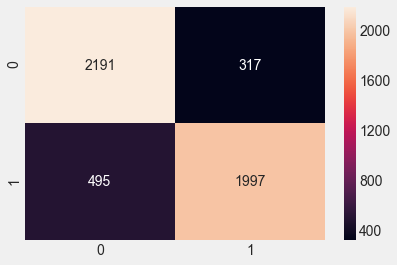



 Classification Report:               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2508
           1       0.86      0.80      0.83      2492

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [233]:
print("Confusion matrix for SVM is : \n\n",sns.heatmap(confusion_matrix(y,pred1), annot = True, fmt = '2.0f'))
plt.show()
print("\n\n Classification Report:" ,classification_report(y,pred1))

## Random Forest

In [228]:
param = {'max_depth':[3, None], 'min_samples_split':[2, 3, 10], 
              'min_samples_leaf':[1, 3, 10], 'bootstrap':[True, False], 
              'criterion':["gini", "entropy"], 
              'n_estimators':[100, 500, 1000, 1500]}

#gd2 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param, cv=5, verbose=1, n_jobs = -1, scoring = "accuracy")
#gd2.fit(X,y)

print(gd2.best_score_)
print(gd2.best_estimator_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 30.5min finished


0.8404
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


The best score for Random Forest Classifier after hyper parameter tuning is found to be 84.04% and the best estimator is:

* RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [234]:
estimator2 = gd2.best_estimator_
pred2 = cross_val_predict(estimator2,X,y,cv=5)

In [235]:
pred2 = pd.DataFrame(pred2,columns= ['RF_prediction'])
pred2

,RF_prediction
0,1
1,0
2,0
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


In [236]:
pred2.to_csv('RF_prediction.csv')

Confusion matrix for Random Forest is : 

 AxesSubplot(0.08,0.07;0.696x0.81)


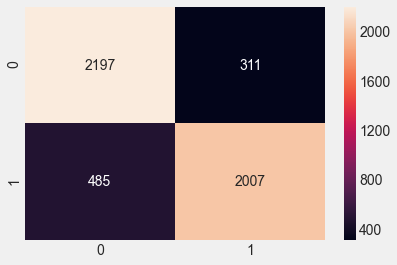



 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2508
           1       0.87      0.81      0.83      2492

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [238]:
print("Confusion matrix for Random Forest is : \n\n",sns.heatmap(confusion_matrix(y,pred2), annot = True, fmt = '2.0f'))
plt.show()
print("\n\n Classification Report:\n" ,classification_report(y,pred2))

## Logistic Regression

In [223]:
param = {'penalty' : ['l1', 'l2'], 'C' : [100, 10, 1.0, 0.1], 'solver' : ['liblinear'] }

#gd3 = GridSearchCV(estimator = LogisticRegression(), param_grid=param, cv=5, verbose=1, n_jobs = -1, scoring = "accuracy" )
#gd3.fit(X,y)

print(gd3.best_score_)
print(gd3.best_estimator_)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.8372
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.3s finished


The best score for Logistic Regression after hyper parameter tuning is found to be 84.00% and the best estimator is:

* LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [239]:
estimator3 = gd3.best_estimator_
pred3 = cross_val_predict(estimator3,X,y,cv=5)

In [240]:
pred3 = pd.DataFrame(pred3,columns= ['LR_prediction'])
pred3

,LR_prediction
0,1
1,0
2,0
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


In [241]:
pred3.to_csv('LR_prediction.csv')

Confusion matrix for Logistic Regression is : 

 AxesSubplot(0.08,0.07;0.696x0.81)


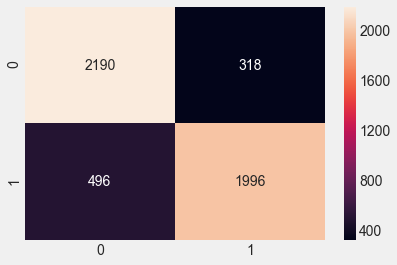



 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2508
           1       0.86      0.80      0.83      2492

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [242]:
print("Confusion matrix for Logistic Regression is : \n\n",sns.heatmap(confusion_matrix(y,pred3), annot = True, fmt = '2.0f'))
plt.show()
print("\n\n Classification Report:\n" ,classification_report(y,pred3))

Here we can conclude that almost all the algorithms are giving a good enough accuracy and also has a similar clasification report, therefore we can fix on one model and take the Random Forest Classifer model as the best possible one.


## Confusion Matrix for Best Model

In [243]:
pred2 = pd.read_csv('RF_prediction.csv', index_col=0)
pred2

,RF_prediction
0,1
1,0
2,0
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


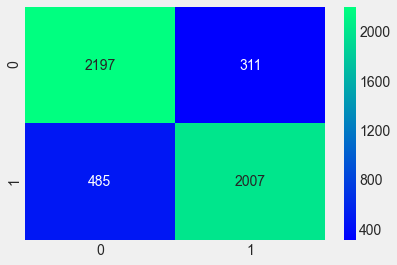

In [244]:
sns.heatmap(confusion_matrix(y,pred2),cmap='winter',annot=True,fmt='2.0f')
plt.show()

Here we can infer the following from the confusion matrix:

* 0 - Not enrolled, 1 - Enrolled
* We have the actual classes on the y-axis and the predicted classes on the x-axis.
* The model is able to dstinguish between the both classes,but still there is some error. 
* 485 samples were actually positive but were predicted as negative -  False Negative
* 311 samples were actually negative but were predicted as positive - False Positive.
* There is margin for improvement of the model.


## Feature Importance

In [245]:
model_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model_best.fit(X,y)
feat = pd.Series(model_best.feature_importances_,X.columns).sort_values(ascending=True)
feat

ProfileEducationMajor   0.00
ProfileEducation        0.00
age_6                   0.00
ProfileMaritalStatus    0.00
ProfileChildren         0.00
VerifyHousingAmount     0.00
VerifyHousing           0.00
EditProfile             0.00
Leaderboard             0.00
Settings                0.00
Finances                0.00
RewardsContainer        0.00
age_5                   0.00
CCCount                 0.00
MLWebView               0.00
ProfilePage             0.00
SavingsCount            0.00
dayofweek_2             0.01
CommunityAndInvites     0.01
dayofweek_1             0.01
age_4                   0.01
liked                   0.01
ReferralContainer       0.01
dayofweek_6             0.01
dayofweek_3             0.01
dayofweek_4             0.01
dayofweek_5             0.01
used_premium_feature    0.01
Alerts                  0.01
Splash                  0.01
Institutions            0.01
age_2                   0.01
minigame                0.01
age_3                   0.01
Cycle         

In [246]:
feat.shape

(56,)

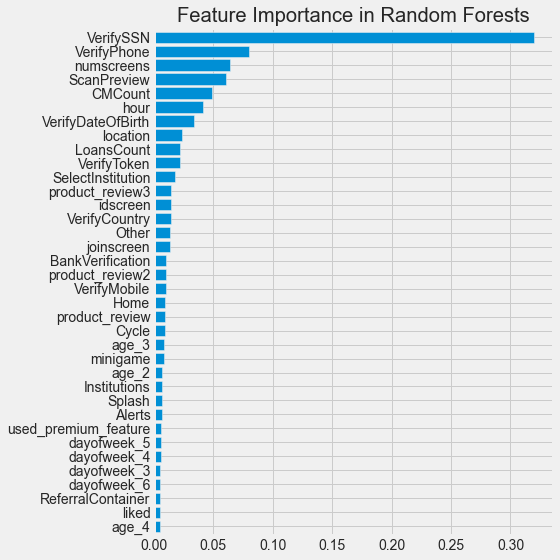

In [247]:
## Most Important Features

plt.figure(figsize = (8,8))
feat[20:].plot.barh(width=0.8)
plt.title('Feature Importance in Random Forests')
plt.tight_layout()

## Conclusion

* Our efforts have given us a model that will label every new user as "highly likely" (or "unlikely") to subscribe but there is still margin for improvement of the model. 

* We also observe through EDA that a lot of the users left the premium subscription after using it. This may be due to the quality issues of premium subscription. Or maybe the users thought the subscription was not worth it.

* While observing the feature importance, we see that a lot of weightage is given to general features and therefore we are not able to make clear differences. There is a need to do further study on other features as well in depth to get more insights.

* We can further validate our results by running our predictions on daily new installs, and see whether our accuracy is consistent. From there, we can narrow our marketing efforts only to those users "unlikely" to subscribe, and thus increase our subscription rate.

* The increase in overall subscriptions can measure the benefits of this model to the company. Note that those already likely to subscribe will do so, and although we can still give them offers, we don't have to go all out. 

* On the other hand, users who are likely to leave may convert to paid subscribers if we give them an offer they cannot refuse. For example, these offers can come in the form of "1st month free", or "50% off yearly subscriptions". The latter shows that great offers can still be structured in a way that brings overall benefits to the company because we are locking the user in for an extended period. This is a model of SaaS services provided through the app.

# Creating Model Pipeline